In [1]:
import numpy as np

from numba import njit, types

import plotly.express as ex

import plotly.graph_objs as go

In [2]:
population_size = 10

In [3]:
individuals = np.random.randint(
    low=1,
    high=9,
    size=(population_size,8))

print(f"{individuals = }")

individuals = array([[6, 8, 5, 6, 1, 1, 4, 5],
       [5, 7, 3, 6, 2, 4, 7, 7],
       [2, 7, 1, 1, 5, 2, 1, 3],
       [8, 8, 1, 7, 3, 6, 1, 1],
       [8, 4, 8, 1, 1, 7, 3, 5],
       [4, 1, 8, 1, 6, 6, 6, 2],
       [7, 1, 1, 2, 8, 3, 5, 4],
       [3, 4, 1, 3, 1, 1, 3, 2],
       [2, 1, 8, 8, 7, 5, 1, 2],
       [2, 6, 3, 6, 8, 7, 7, 3]])


In [4]:
@njit()
def evaluate_one(individual: np.array) -> int:
    num_attacks = 0
    
    for i in range(7):  # Assumes chess board of side length 8
        for j in range(i+1, 8):
            if individual[i] == individual[j]:
                num_attacks += 1
            elif abs(individual[i] - individual[j]) == j - i:
                num_attacks += 1
    return num_attacks

@njit()
def evaluate(individuals: np.ndarray)-> np.ndarray:
    output = np.zeros(
        len(individuals),
        dtype=types.int16
    )
    
    for i in range(len(individuals)):
        output[i] = evaluate_one(individuals[i])
    return output



In [5]:
# Testing some positions
# This should be 28

evaluate_one(
    np.array([1,1,1,1,1,1,1,1])
)

28

In [6]:
# This is a valid solution to the 8 queens puzzle
evaluate_one(
    np.array([5,3,1,7,2,8,6,4])
)

0

In [7]:
evaluate(individuals)

array([ 7,  6,  5,  7,  6,  7,  5, 12,  8,  6], dtype=int16)

In [10]:
@njit
def crossover(individuals: np.array) -> np.array:
    """Implements one point crossover."""
    offsprings = np.zeros_like(individuals)
    
    # Randomize the parent pairs
    order = np.random.permutation(len(individuals))
    
    for i in range(0, len(individuals), 2):
        crossover_point = np.random.randint(0,7)
        
        # First offspring
        offsprings[order[i], :crossover_point+1] = individuals[order[i], :crossover_point+1]
        offsprings[order[i], crossover_point+1:] = individuals[order[i + 1], crossover_point+1:]
        
        # Second offspring
        offsprings[order[i + 1], :crossover_point+1] = individuals[order[i + 1], :crossover_point+1]
        offsprings[order[i + 1], crossover_point+1:] = individuals[order[i], crossover_point+1:]
    return offsprings

In [11]:
@njit
def mutate(individuals: np.ndarray) -> np.ndarray:
    mut_probability = 0.3
    for i in range(len(individuals)):
        for j in range(8):
            if np.random.rand() > mut_probability:
                continue
            if np.random.rand() < 0.5:
                individuals[i,j] -=1
            else:
                individuals[i,j] +=1
            if individuals[i,j]>8:
                individuals[i,j] = individuals[i,j] - 8
            elif individuals[i,j]<1:
                individuals[i,j] = individuals[i,j] + 8
    return individuals

In [22]:
@njit()
def select(fitness:np.array):
    return fitness.argsort()[:len(fitness)/2]

@njit()
def tournament_select(fitness:np.ndarray):
    
    probability_choose_worse = 0.05
    
    # Randomize the tournament pairs
    order = np.random.permutation(len(fitness))
    selected = np.zeros_like(order)
    for i in range(0,len(fitness),2):
        individual_one = order[i]
        individual_two = order[i + 1]
        if fitness[individual_one] < fitness[individual_two]:
            better = individual_one
            worse = individual_two
        else:
            better = individual_two
            worse = individual_one
        if np.random.rand() < probability_choose_worse:
            selected[worse] = 1
        else:
            selected[better] = 1
    return np.where(selected==1)
        

In [23]:
@njit()
def run_one_gen(population:np.array, fitness:np.array) -> tuple:
    offsprings = crossover(population)
    offsprings = mutate(offsprings)
    
    fitness_offsprings = evaluate(offsprings)
    
    new_population = np.vstack((population, offsprings))
    new_fitness = np.hstack((fitness, fitness_offsprings))
    
    selected_individuals = tournament_select(new_fitness)
    
    return new_population[selected_individuals], new_fitness[selected_individuals]


In [24]:
@njit
def run_EA(population:np.array) -> tuple:
    number_generations = 1000
    fitness = evaluate(population)
    fitness_archive = np.atleast_2d(fitness)
    
    for i in range(1, number_generations):
        if (fitness == 0).any():
            break
        population, fitness = run_one_gen(population, fitness)
        fitness_archive = np.vstack((fitness_archive, np.atleast_2d(fitness)))
    return population, fitness_archive, i

In [25]:
population_size=10

individuals = np.random.randint(
    low=1,
    high=9,
    size=(population_size,8)
)
individuals, performance_archive, last_gen = run_EA(individuals)

print(f"{last_gen = }")

last_gen = 86


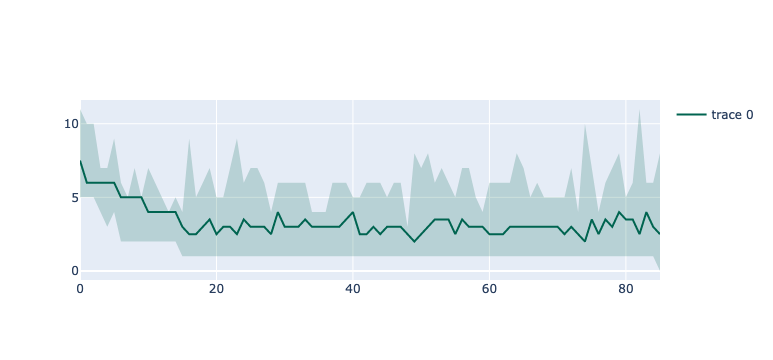

In [26]:
x = list(range(last_gen))

y = np.median(performance_archive, axis=1)




fig = go.Figure([
    go.Scatter(
        x=x,
        y=y,
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
    go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=(performance_archive.max(axis=1)).tolist()+(performance_archive.min(axis=1)).tolist()[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
])
fig.show()